In [3]:
import pandas as pd
# Φόρτωση δεδομένων
file_path = r'C:\Users\emexi\Desktop\Aviation_Project\Preprocessed_file.csv'
data = pd.read_csv(file_path, encoding='latin1')

# Στήλες στόχοι (Target columns)
target_columns = [
    "Understanding job ro_1", "Understanding job ro_2", "Understanding job ro_3", "Understanding job ro_4", "Understanding job ro_5",
    "Teamwork emergencies_1", "Teamwork emergencies_2", "Teamwork emergencies_3", "Teamwork emergencies_4", "Teamwork emergencies_5",
    "Teamwork and communi_1", "Teamwork and communi_2", "Teamwork and communi_3", "Teamwork and communi_4", "Teamwork and communi_5",
    "Teamwork and communi_6", "Teamwork and communi_7", "Teamwork and communi_8", "Teamwork and communi_9", "Teamwork and communi_10",
    "Teamwork and communi_11", "Teamwork and communi_12", "Teamwork and communi_13", "Teamwork and communi_14", "Teamwork and communi_15",
    "Clear communication_1", "Clear communication_2", "Clear communication_3", "Clear communication_4", "Clear communication_5",
    "Clear communication_6", "Clear communication_7", "Clear communication_8", "Clear communication_9"
]

# Ορισμός κατηγοριών
categories = {
    "Understanding of job roles": [
        "Understanding job ro_1", "Understanding job ro_2", "Understanding job ro_3",
        "Understanding job ro_4", "Understanding job ro_5"
    ],
    "Teamwork in emergencies": [
        "Teamwork emergencies_1", "Teamwork emergencies_2", "Teamwork emergencies_3",
        "Teamwork emergencies_4", "Teamwork emergencies_5"
    ],
    "Overall importance of effective teamwork and communication": [
        "Teamwork and communi_1", "Teamwork and communi_2", "Teamwork and communi_3",
        "Teamwork and communi_4", "Teamwork and communi_5", "Teamwork and communi_6",
        "Teamwork and communi_7", "Teamwork and communi_8", "Teamwork and communi_9",
        "Teamwork and communi_10", "Teamwork and communi_11", "Teamwork and communi_12",
        "Teamwork and communi_13", "Teamwork and communi_14", "Teamwork and communi_15"
    ],
    "Importance of clear communication within the maintenance team": [
        "Clear communication_1", "Clear communication_2", "Clear communication_3",
        "Clear communication_4", "Clear communication_5", "Clear communication_6",
        "Clear communication_7", "Clear communication_8", "Clear communication_9"
    ]
}


In [23]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, f1_score

# Χωρισμός χαρακτηριστικών και στόχων
input_features = data.drop(columns=target_columns)
targets = data[target_columns]

# Προεπεξεργασία χαρακτηριστικών (Κλιμάκωση)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(input_features)

# Λειτουργία για υπολογισμό των σημαντικών χαρακτηριστικών
def get_important_features(input_features, targets, num_features):
    feature_importances = {}

    for target in targets.columns:
        # Δημιουργία training/test datasets
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, targets[target], test_size=0.2, random_state=42
        )

        # Logistic Regression
        log_reg = LogisticRegression(max_iter=500, random_state=42)
        log_reg.fit(X_train, y_train)

        # Αποθήκευση της σημαντικότητας χαρακτηριστικών (coefficient magnitudes)
        # Sum of absolute values of coefficients for all classes
        feature_importances[target] = np.sum(np.abs(log_reg.coef_), axis=0)

    # Υπολογισμός μέσης σημαντικότητας για όλα τα targets
    mean_importance = pd.DataFrame(feature_importances).mean(axis=1)
    important_features = pd.DataFrame({
        'Feature': input_features.columns,
        'Importance': mean_importance
    }).sort_values(by='Importance', ascending=False)

    # Επιλογή των πιο σημαντικών χαρακτηριστικών
    selected_features = important_features.head(num_features)['Feature'].tolist()
    return selected_features

# Δοκιμή για διάφορους αριθμούς σημαντικών χαρακτηριστικών
def evaluate_for_top_features(input_features, targets, feature_counts=[5, 10, 15, 20, 25]):
    results = {}

    for num_features in feature_counts:
        print(f"\nEvaluating for the top {num_features} important features...")

        # Επιλογή των πιο σημαντικών χαρακτηριστικών
        selected_features = get_important_features(input_features, targets, num_features)
        X_selected = pd.DataFrame(X_scaled, columns=input_features.columns)[selected_features]

        # Χωρισμός σε σύνολα εκπαίδευσης και δοκιμής
        X_train, X_test, y_train, y_test = train_test_split(X_selected, targets, test_size=0.2, random_state=42)

        # Αρχικοποίηση του Logistic Regression και MultiOutputClassifier
        log_reg_model = LogisticRegression(max_iter=500, random_state=42)
        multi_target_model = MultiOutputClassifier(log_reg_model)

        # Εκπαίδευση του MultiOutputClassifier
        print("Training the MultiOutputClassifier...")
        multi_target_model.fit(X_train, y_train)

        # Πρόβλεψη στο σύνολο δοκιμής
        print("Predicting on the test set...")
        y_pred = multi_target_model.predict(X_test)

        # Αξιολόγηση: Ακρίβεια και F1-score για κάθε κατηγορία
        category_accuracy = {}
        category_f1 = {}

        for category, questions in categories.items():
            acc = []
            f1 = []

            for q in questions:
                if q in targets.columns:
                    acc.append(accuracy_score(y_test[q], y_pred[:, targets.columns.get_loc(q)]))
                    f1.append(f1_score(y_test[q], y_pred[:, targets.columns.get_loc(q)], average='weighted', zero_division=0))

            category_accuracy[category] = np.mean(acc) if acc else None
            category_f1[category] = np.mean(f1) if f1 else None

        # Αποθήκευση αποτελεσμάτων
        results[num_features] = {
            'category_accuracy': category_accuracy,
            'category_f1': category_f1
        }

    return results

# Εκτέλεση του evaluation για τα top χαρακτηριστικά
results = evaluate_for_top_features(input_features, targets, feature_counts=[5, 10, 15, 20, 25])

# Εκτύπωση αποτελεσμάτων για κάθε αριθμό χαρακτηριστικών
for num_features in results:
    print(f"\nResults for top {num_features} important features:")
    category_accuracy = results[num_features]['category_accuracy']
    category_f1 = results[num_features]['category_f1']
    
    for category in categories:
        print(f"Category: {category}")
        print(f"  Average Accuracy: {category_accuracy[category]:.4f}" if category_accuracy[category] is not None else "  No Accuracy Data")
        print(f"  Average F1 Score: {category_f1[category]:.4f}" if category_f1[category] is not None else "  No F1 Score Data")



Evaluating for the top 5 important features...
Training the MultiOutputClassifier...
Predicting on the test set...

Evaluating for the top 10 important features...
Training the MultiOutputClassifier...
Predicting on the test set...

Evaluating for the top 15 important features...
Training the MultiOutputClassifier...
Predicting on the test set...

Evaluating for the top 20 important features...
Training the MultiOutputClassifier...
Predicting on the test set...

Evaluating for the top 25 important features...
Training the MultiOutputClassifier...
Predicting on the test set...

Results for top 5 important features:
Category: Understanding of job roles
  Average Accuracy: 0.5371
  Average F1 Score: 0.4859
Category: Teamwork in emergencies
  Average Accuracy: 0.3829
  Average F1 Score: 0.3417
Category: Overall importance of effective teamwork and communication
  Average Accuracy: 0.4533
  Average F1 Score: 0.3992
Category: Importance of clear communication within the maintenance team
  A

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, LeaveOneOut
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

# Load the data
file_path = r'C:\Users\emexi\Desktop\Aviation_Project\modified_dataframe.csv'
df = pd.read_csv(file_path, encoding='latin1')

# Split the input features (X) and targets (Y)
input_features = df.drop(columns=[f"Q{i}" for i in range(1, 35)])
targets = df[[f"Q{i}" for i in range(1, 35)]]

# Feature preprocessing (Standardization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(input_features)

# Initialize dictionaries to store scores
cv_scores_accuracy = {}
cv_scores_f1 = {}
final_scores_accuracy = {}
final_scores_f1 = {}

# Logistic Regression settings
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Apply Logistic Regression for each target
for target in targets.columns:
    try:
        print(f"Processing target: {target}")
        
        # Check class distribution for each target
        print(f"Class distribution for {target}:")
        print(targets[target].value_counts())

        # Find the smallest class size for this target
        min_class_size = targets[target].value_counts().min()
        
        # Determine the appropriate number of splits for cross-validation
        n_splits = min(5, len(targets[target].unique()))  # at least 2 splits and cannot exceed unique class count
        # If the minimum class size is smaller than n_splits, adjust n_splits
        n_splits = min(n_splits, min_class_size)
        # Set cross-validation strategy
        if min_class_size == 1:
            cv = LeaveOneOut()  # Use LeaveOneOut for very small classes with only 1 sample
        else:
            cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)  # StratifiedKFold for larger datasets

        # Create training/test datasets
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, targets[target], test_size=0.2, random_state=42)
        
        # Perform cross-validation and store the average score for accuracy
        accuracy_scores = cross_val_score(log_reg, X_scaled, targets[target], cv=cv, scoring='accuracy')
        cv_scores_accuracy[target] = accuracy_scores
        print(f"Cross-validation accuracy scores for {target}: {accuracy_scores}")
        
        # Perform cross-validation and store the average score for F1
        f1_scores = cross_val_score(log_reg, X_scaled, targets[target], cv=cv, scoring='f1_weighted')
        cv_scores_f1[target] = f1_scores
        print(f"Cross-validation F1 scores for {target}: {f1_scores}")
        
        # Train the Logistic Regression model on the training data
        log_reg.fit(X_train, y_train)

        # Store the final accuracy and F1 score on the test data
        y_pred = log_reg.predict(X_test)
        final_accuracy = accuracy_score(y_test, y_pred)
        final_f1 = f1_score(y_test, y_pred, average='weighted')
        
        final_scores_accuracy[target] = final_accuracy
        final_scores_f1[target] = final_f1
        
        print(f"Final accuracy for {target} on test set: {final_accuracy}")
        print(f"Final F1 score for {target} on test set: {final_f1}")

    except Exception as e:
        print(f"Error processing {target}: {e}")


# Define the categories
categories = {
    "Understanding of job roles": [f"Q{i}" for i in range(1, 6)],
    "Teamwork in emergencies": [f"Q{i}" for i in range(6, 11)],
    "Overall importance of effective teamwork and communication": [f"Q{i}" for i in range(11, 26)],
    "Importance of clear communication within the maintenance team": [f"Q{i}" for i in range(26, 35)]
}

# Initialize dictionaries to store averages
average_accuracy = {}
average_f1 = {}

# Calculate averages for each category
for category, questions in categories.items():
    accuracies = [final_scores_accuracy[q] for q in questions if q in final_scores_accuracy]
    f1_scores = [final_scores_f1[q] for q in questions if q in final_scores_f1]

    if accuracies:
        average_accuracy[category] = np.mean(accuracies)
    else:
        average_accuracy[category] = None  # No scores available for this category

    if f1_scores:
        average_f1[category] = np.mean(f1_scores)
    else:
        average_f1[category] = None  # No scores available for this category

# Print the results
for category in categories:
    print(f"Category: {category}")
    print(f"  Average Accuracy: {average_accuracy[category]:.4f}" if average_accuracy[category] is not None else "  No Accuracy Data")
    print(f"  Average F1 Score: {average_f1[category]:.4f}" if average_f1[category] is not None else "  No F1 Score Data")




Processing target: Q1
Class distribution for Q1:
Q1
5    127
4     37
3      6
2      3
Name: count, dtype: int64
Cross-validation accuracy scores for Q1: [0.63793103 0.67241379 0.59649123]
Cross-validation F1 scores for Q1: [0.62253918 0.64022989 0.62693263]
Final accuracy for Q1 on test set: 0.7142857142857143
Final F1 score for Q1 on test set: 0.6989795918367346
Processing target: Q2
Class distribution for Q2:
Q2
4    82
5    58
3    20
2     9
1     4
Name: count, dtype: int64
Cross-validation accuracy scores for Q2: [0.34090909 0.51162791 0.39534884 0.44186047]
Cross-validation F1 scores for Q2: [0.32859848 0.49220108 0.39186047 0.43887191]
Final accuracy for Q2 on test set: 0.4
Final F1 score for Q2 on test set: 0.39549805033676
Processing target: Q3
Class distribution for Q3:
Q3
5    75
4    71
3    17
2     7
1     3
Name: count, dtype: int64
Cross-validation accuracy scores for Q3: [0.51724138 0.44827586 0.49122807]
Cross-validation F1 scores for Q3: [0.49862342 0.43421956 0.4

In [6]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, LeaveOneOut
from sklearn.metrics import accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Load the data
file_path = r'C:\Users\emexi\Desktop\Aviation_Project\modified_dataframe.csv'
df = pd.read_csv(file_path, encoding='latin1')

# Split the input features (X) and targets (Y)
input_features = df.drop(columns=[f"Q{i}" for i in range(1, 35)])
targets = df[[f"Q{i}" for i in range(1, 35)]]

# Feature preprocessing (Standardization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(input_features)

# Initialize dictionaries to store scores
cv_scores_accuracy = {}
cv_scores_f1 = {}
final_scores_accuracy = {}
final_scores_f1 = {}

# Logistic Regression settings
log_reg = LogisticRegression(max_iter=1000, random_state=42)

from imblearn.over_sampling import SMOTE

for target in targets.columns:
    try:
        print(f"Processing target: {target}")
        
        # Check class distribution for each target
        print(f"Class distribution for {target}:")
        print(targets[target].value_counts())

        # Find the smallest class size for this target
        min_class_size = targets[target].value_counts().min()
        
        # Determine the appropriate number of splits for cross-validation
        n_splits = min(5, len(targets[target].unique()))
        n_splits = min(n_splits, min_class_size)
        if min_class_size == 1:
            cv = LeaveOneOut()
        else:
            cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

        # Create training/test datasets
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, targets[target], test_size=0.2, random_state=42)
        
        # Adjust SMOTE's k_neighbors dynamically
        smote_k_neighbors = min(5, min_class_size - 1) if min_class_size > 1 else 1
        smote = SMOTE(k_neighbors=smote_k_neighbors, random_state=42)
        
        # Apply SMOTE if it can be performed
        if min_class_size > 1:
            X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
            print(f"After SMOTE resampling for {target}:")
            print(pd.Series(y_train_resampled).value_counts())
        else:
            print(f"Skipping SMOTE for {target} due to insufficient samples in minority class.")
            X_train_resampled, y_train_resampled = X_train, y_train

        # Perform model training and evaluation
        log_reg.fit(X_train_resampled, y_train_resampled)
        y_pred = log_reg.predict(X_test)
        final_accuracy = accuracy_score(y_test, y_pred)
        final_f1 = f1_score(y_test, y_pred, average='weighted')

        final_scores_accuracy[target] = final_accuracy
        final_scores_f1[target] = final_f1
        
        print(f"Final accuracy for {target} on test set: {final_accuracy}")
        print(f"Final F1 score for {target} on test set: {final_f1}")

    except Exception as e:
        print(f"Error processing {target}: {e}")


# Define the categories
categories = {
    "Understanding of job roles": [f"Q{i}" for i in range(1, 6)],
    "Teamwork in emergencies": [f"Q{i}" for i in range(6, 11)],
    "Overall importance of effective teamwork and communication": [f"Q{i}" for i in range(11, 26)],
    "Importance of clear communication within the maintenance team": [f"Q{i}" for i in range(26, 35)]
}

# Initialize dictionaries to store averages
average_accuracy = {}
average_f1 = {}

# Calculate averages for each category
for category, questions in categories.items():
    accuracies = [final_scores_accuracy[q] for q in questions if q in final_scores_accuracy]
    f1_scores = [final_scores_f1[q] for q in questions if q in final_scores_f1]

    if accuracies:
        average_accuracy[category] = np.mean(accuracies)
    else:
        average_accuracy[category] = None  # No scores available for this category

    if f1_scores:
        average_f1[category] = np.mean(f1_scores)
    else:
        average_f1[category] = None  # No scores available for this category

# Print the results
for category in categories:
    print(f"Category: {category}")
    print(f"  Average Accuracy: {average_accuracy[category]:.4f}" if average_accuracy[category] is not None else "  No Accuracy Data")
    print(f"  Average F1 Score: {average_f1[category]:.4f}" if average_f1[category] is not None else "  No F1 Score Data")


Processing target: Q1
Class distribution for Q1:
Q1
5    127
4     37
3      6
2      3
Name: count, dtype: int64
After SMOTE resampling for Q1:
Q1
5    100
4    100
2    100
3    100
Name: count, dtype: int64
Final accuracy for Q1 on test set: 0.5714285714285714
Final F1 score for Q1 on test set: 0.6092100840336134
Processing target: Q2
Class distribution for Q2:
Q2
4    82
5    58
3    20
2     9
1     4
Name: count, dtype: int64
After SMOTE resampling for Q2:
Q2
4    70
5    70
2    70
3    70
1    70
Name: count, dtype: int64
Final accuracy for Q2 on test set: 0.37142857142857144
Final F1 score for Q2 on test set: 0.38253126184160663
Processing target: Q3
Class distribution for Q3:
Q3
5    75
4    71
3    17
2     7
1     3
Name: count, dtype: int64
After SMOTE resampling for Q3:
Q3
5    62
4    62
3    62
2    62
1    62
Name: count, dtype: int64
Final accuracy for Q3 on test set: 0.4857142857142857
Final F1 score for Q3 on test set: 0.46890756302521014
Processing target: Q4
Class

In [8]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, LeaveOneOut
from sklearn.metrics import accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
import matplotlib.pyplot as plt

# Load the data
file_path = r'C:\Users\emexi\Desktop\Aviation_Project\modified_dataframe.csv'
df = pd.read_csv(file_path, encoding='latin1')

# Split the input features (X) and targets (Y)
input_features = df.drop(columns=[f"Q{i}" for i in range(1, 35)])
targets = df[[f"Q{i}" for i in range(1, 35)]]

# Feature preprocessing (Standardization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(input_features)

# Initialize dictionaries to store scores
final_scores_accuracy = {}
final_scores_f1 = {}

# Logistic Regression settings
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Initialize Tomek Links
tomek = TomekLinks()

for target in targets.columns:
    try:
        print(f"Processing target: {target}")
        
        # Check class distribution for each target
        print(f"Class distribution for {target}:")
        print(targets[target].value_counts())

        # Find the smallest class size for this target
        min_class_size = targets[target].value_counts().min()
        
        # Determine the appropriate number of splits for cross-validation
        n_splits = min(5, len(targets[target].unique()))
        n_splits = min(n_splits, min_class_size)
        if min_class_size == 1:
            cv = LeaveOneOut()
        else:
            cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

        # Create training/test datasets
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, targets[target], test_size=0.2, random_state=42)
        
        # Adjust SMOTE's k_neighbors dynamically
        smote_k_neighbors = min(5, min_class_size - 1) if min_class_size > 1 else 1
        smote = SMOTE(k_neighbors=smote_k_neighbors, random_state=42)
        
        # Apply SMOTE if it can be performed
        if min_class_size > 1:
            X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
            print(f"After SMOTE resampling for {target}:")
            print(pd.Series(y_train_resampled).value_counts())
        else:
            print(f"Skipping SMOTE for {target} due to insufficient samples in minority class.")
            X_train_resampled, y_train_resampled = X_train, y_train
        
        # Apply Tomek Links to clean the dataset
        X_train_resampled, y_train_resampled = tomek.fit_resample(X_train_resampled, y_train_resampled)
        print(f"After Tomek Links cleaning for {target}:")
        print(pd.Series(y_train_resampled).value_counts())

        # Perform model training and evaluation
        log_reg.fit(X_train_resampled, y_train_resampled)
        y_pred = log_reg.predict(X_test)
        final_accuracy = accuracy_score(y_test, y_pred)
        final_f1 = f1_score(y_test, y_pred, average='weighted')

        final_scores_accuracy[target] = final_accuracy
        final_scores_f1[target] = final_f1
        
        print(f"Final accuracy for {target} on test set: {final_accuracy}")
        print(f"Final F1 score for {target} on test set: {final_f1}")

    except Exception as e:
        print(f"Error processing {target}: {e}")


# Define the categories
categories = {
    "Understanding of job roles": [f"Q{i}" for i in range(1, 6)],
    "Teamwork in emergencies": [f"Q{i}" for i in range(6, 11)],
    "Overall importance of effective teamwork and communication": [f"Q{i}" for i in range(11, 26)],
    "Importance of clear communication within the maintenance team": [f"Q{i}" for i in range(26, 35)]
}

# Initialize dictionaries to store averages
average_accuracy = {}
average_f1 = {}

# Calculate averages for each category
for category, questions in categories.items():
    accuracies = [final_scores_accuracy[q] for q in questions if q in final_scores_accuracy]
    f1_scores = [final_scores_f1[q] for q in questions if q in final_scores_f1]

    if accuracies:
        average_accuracy[category] = np.mean(accuracies)
    else:
        average_accuracy[category] = None  # No scores available for this category

    if f1_scores:
        average_f1[category] = np.mean(f1_scores)
    else:
        average_f1[category] = None  # No scores available for this category

# Print the results
for category in categories:
    print(f"Category: {category}")
    print(f"  Average Accuracy: {average_accuracy[category]:.4f}" if average_accuracy[category] is not None else "  No Accuracy Data")
    print(f"  Average F1 Score: {average_f1[category]:.4f}" if average_f1[category] is not None else "  No F1 Score Data")


Processing target: Q1
Class distribution for Q1:
Q1
5    127
4     37
3      6
2      3
Name: count, dtype: int64
After SMOTE resampling for Q1:
Q1
5    100
4    100
2    100
3    100
Name: count, dtype: int64
After Tomek Links cleaning for Q1:
Q1
5    100
4    100
2    100
3    100
Name: count, dtype: int64
Final accuracy for Q1 on test set: 0.5714285714285714
Final F1 score for Q1 on test set: 0.6092100840336134
Processing target: Q2
Class distribution for Q2:
Q2
4    82
5    58
3    20
2     9
1     4
Name: count, dtype: int64
After SMOTE resampling for Q2:
Q2
4    70
5    70
2    70
3    70
1    70
Name: count, dtype: int64
After Tomek Links cleaning for Q2:
Q2
2    70
3    70
1    70
4    69
5    69
Name: count, dtype: int64
Final accuracy for Q2 on test set: 0.34285714285714286
Final F1 score for Q2 on test set: 0.3514285714285714
Processing target: Q3
Class distribution for Q3:
Q3
5    75
4    71
3    17
2     7
1     3
Name: count, dtype: int64
After SMOTE resampling for Q3:
Q3

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import f1_score, accuracy_score

# -------------------------------
# Data Loading and Preparation
# -------------------------------
file_path = r'C:\Users\Χρήστος\Desktop\Aviation_Project\Preprocessed_file.csv'
data = pd.read_csv(file_path, encoding='latin1')

# Define target columns and category grouping
target_columns = [
    "SA_1_understanding_job_roles",
    "SA_2_understanding_job_roles",
    "SA_3_understanding_job_roles",
    "SA_4_understanding_job_roles",
    "SA_5_understanding_job_roles",
    "SA_6_teamwork_in_emergencies",
    "SA_7_teamwork_in_emergencies",
    "SA_8_teamwork_in_emergencies",
    "SA_9_teamwork_in_emergencies",
    "SA_10_teamwork_in_emergencies",
    "SA_11_teamwork_and_communication",
    "SA_12_teamwork_and_communication",
    "SA_13_teamwork_and_communication",
    "SA_14_teamwork_and_communication",
    "SA_15_teamwork_and_communication",
    "SA_16R_teamwork_and_communication",
    "SA_17_teamwork_and_communication",
    "SA_18_teamwork_and_communication",
    "SA_19_teamwork_and_communication",
    "SA_20_teamwork_and_communication",
    "SA_21_teamwork_and_communication",
    "SA_22R_teamwork_and_communication",
    "SA_23_teamwork_and_communication",
    "SA_24_teamwork_and_communication",
    "SA_25_teamwork_and_communication",
    "SA_26_clear_communication_within_team",
    "SA_27_clear_communication_within_team",
    "SA_28_clear_communication_within_team",
    "SA_29_clear_communication_within_team",
    "SA_30_clear_communication_within_team",
    "SA_31_clear_communication_within_team",
    "SA_32_clear_communication_within_team",
    "SA_33_clear_communication_within_team",
    "SA_34R_clear_communication_within_team"
]

categories = {
    "Understanding of job roles": [
        "SA_1_understanding_job_roles",
        "SA_2_understanding_job_roles",
        "SA_3_understanding_job_roles",
        "SA_4_understanding_job_roles",
        "SA_5_understanding_job_roles"
    ],
    "Teamwork in emergencies": [
        "SA_6_teamwork_in_emergencies",
        "SA_7_teamwork_in_emergencies",
        "SA_8_teamwork_in_emergencies",
        "SA_9_teamwork_in_emergencies",
        "SA_10_teamwork_in_emergencies"
    ],
    "Overall importance of effective teamwork and communication": [
        "SA_11_teamwork_and_communication",
        "SA_12_teamwork_and_communication",
        "SA_13_teamwork_and_communication",
        "SA_14_teamwork_and_communication",
        "SA_15_teamwork_and_communication",
        "SA_16R_teamwork_and_communication",
        "SA_17_teamwork_and_communication",
        "SA_18_teamwork_and_communication",
        "SA_19_teamwork_and_communication",
        "SA_20_teamwork_and_communication",
        "SA_21_teamwork_and_communication",
        "SA_22R_teamwork_and_communication",
        "SA_23_teamwork_and_communication",
        "SA_24_teamwork_and_communication",
        "SA_25_teamwork_and_communication"
    ],
    "Importance of clear communication within the maintenance team": [
        "SA_26_clear_communication_within_team",
        "SA_27_clear_communication_within_team",
        "SA_28_clear_communication_within_team",
        "SA_29_clear_communication_within_team",
        "SA_30_clear_communication_within_team",
        "SA_31_clear_communication_within_team",
        "SA_32_clear_communication_within_team",
        "SA_33_clear_communication_within_team",
        "SA_34R_clear_communication_within_team"
    ]
}

# Separate input features and targets
input_features = data.drop(columns=target_columns)
targets = data[target_columns]

# Scale the input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(input_features)

# --------------------------------------------
# Function: Feature Importance using Logistic Regression
# --------------------------------------------
def get_important_features_logistic(input_features, targets, num_features):
    feature_importances = {}
    # For each target, fit a logistic regression and compute the mean absolute coefficient
    for target in targets.columns:
        X_train_tmp, X_test_tmp, y_train_tmp, y_test_tmp = train_test_split(
            X_scaled, targets[target], test_size=0.2, random_state=42
        )
        lr = LogisticRegression(random_state=42, max_iter=1000)
        lr.fit(X_train_tmp, y_train_tmp)
        # For binary classification, lr.coef_ is shape (1, n_features)
        # For multiclass, average the absolute values across classes.
        importance = np.mean(np.abs(lr.coef_), axis=0)
        feature_importances[target] = importance
    
    # Average importances across targets
    mean_importance = pd.DataFrame(feature_importances).mean(axis=1)
    important_features = pd.DataFrame({
        'Feature': input_features.columns,
        'Importance': mean_importance
    }).sort_values(by='Importance', ascending=False)
    selected_features = important_features.head(num_features)['Feature'].tolist()
    return selected_features

# -------------------------------------------------------
# Function: Evaluate Model using 5-Fold Cross Validation
# -------------------------------------------------------
def evaluate_features_cv(num_features, cv=5):
    # Select features based on Logistic Regression importance
    selected_features = get_important_features_logistic(input_features, targets, num_features)
    X_selected = pd.DataFrame(X_scaled, columns=input_features.columns)[selected_features]
    
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    fold_f1_scores = []
    fold_accuracy_scores = []
    
    for train_index, test_index in kf.split(X_selected):
        X_train, X_test = X_selected.iloc[train_index], X_selected.iloc[test_index]
        y_train, y_test = targets.iloc[train_index], targets.iloc[test_index]
        
        lr_model = LogisticRegression(random_state=42, max_iter=1000)
        multi_target_model = MultiOutputClassifier(lr_model)
        multi_target_model.fit(X_train, y_train)
        y_pred = multi_target_model.predict(X_test)
        
        fold_f1 = []
        fold_acc = []
        for col in targets.columns:
            idx = targets.columns.get_loc(col)
            fold_f1.append(f1_score(y_test[col], y_pred[:, idx], average='weighted', zero_division=0))
            fold_acc.append(accuracy_score(y_test[col], y_pred[:, idx]))
        fold_f1_scores.append(np.mean(fold_f1))
        fold_accuracy_scores.append(np.mean(fold_acc))
    
    overall_f1 = np.mean(fold_f1_scores)
    overall_accuracy = np.mean(fold_accuracy_scores)
    return overall_f1, overall_accuracy, selected_features

# ---------------------------------------------------------
# Loop Over a Range of Feature Counts to Find the Best Value
# ---------------------------------------------------------
best_num = None
best_f1 = -1
best_accuracy = -1
best_features = None
results = {}

# Try feature counts from 10 up to the total number of input features, in steps of 10
for num in range(10, input_features.shape[1] + 1, 10):
    print(f"Evaluating model with {num} features using 5-fold CV...")
    current_f1, current_acc, current_features = evaluate_features_cv(num, cv=5)
    results[num] = {"f1": current_f1, "accuracy": current_acc}
    print(f"  Average weighted F1 Score: {current_f1:.4f}")
    print(f"  Average Accuracy: {current_acc:.4f}")
    
    # Select best feature count based on F1 score
    if current_f1 > best_f1:
        best_f1 = current_f1
        best_accuracy = current_acc
        best_num = num
        best_features = current_features

print("\nOptimization complete.")
print(f"Best number of features: {best_num}")
print(f"Best CV Average weighted F1 Score: {best_f1:.4f}")
print(f"Best CV Average Accuracy: {best_accuracy:.4f}")
print("Selected Features:", best_features)

# ---------------------------------------------------------
# Final Model Training with the Optimal Number of Features
# ---------------------------------------------------------
print("\nTraining final model using the best number of features...")

X_selected_final = pd.DataFrame(X_scaled, columns=input_features.columns)[best_features]

# Held-out test evaluation using a fixed 80/20 split
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_selected_final, targets, test_size=0.2, random_state=42
)

lr_final = LogisticRegression(random_state=42, max_iter=1000)
multi_target_final = MultiOutputClassifier(lr_final)
multi_target_final.fit(X_train_final, y_train_final)
y_pred_final = multi_target_final.predict(X_test_final)

print("\nFinal Evaluation on Held-out Test Set (Single Split):")
for category, questions in categories.items():
    acc_list = []
    f1_list = []
    for q in questions:
        if q in targets.columns:
            idx = targets.columns.get_loc(q)
            acc_list.append(accuracy_score(y_test_final[q], y_pred_final[:, idx]))
            f1_list.append(f1_score(y_test_final[q], y_pred_final[:, idx], average='weighted', zero_division=0))
    if acc_list and f1_list:
        print(f"Category: {category}")
        print(f"  Average Accuracy: {np.mean(acc_list):.4f}")
        print(f"  Average F1 Score: {np.mean(f1_list):.4f}")
    else:
        print(f"Category: {category} - No Data Available")

# ---------------------------------------------------------
# Final Evaluation using 5-Fold Cross Validation (Category-wise)
# ---------------------------------------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {cat: {"acc": [], "f1": []} for cat in categories.keys()}

for train_index, test_index in kf.split(X_selected_final):
    X_train_cv, X_test_cv = X_selected_final.iloc[train_index], X_selected_final.iloc[test_index]
    y_train_cv, y_test_cv = targets.iloc[train_index], targets.iloc[test_index]
    
    multi_target_final.fit(X_train_cv, y_train_cv)
    y_pred_cv = multi_target_final.predict(X_test_cv)
    
    for cat, questions in categories.items():
        cat_acc = []
        cat_f1 = []
        for q in questions:
            if q in targets.columns:
                idx = targets.columns.get_loc(q)
                cat_acc.append(accuracy_score(y_test_cv[q], y_pred_cv[:, idx]))
                cat_f1.append(f1_score(y_test_cv[q], y_pred_cv[:, idx], average='weighted', zero_division=0))
        if cat_acc:
            cv_results[cat]["acc"].append(np.mean(cat_acc))
        if cat_f1:
            cv_results[cat]["f1"].append(np.mean(cat_f1))

print("\nFinal Evaluation using 5-Fold CV (Category-wise):")
for cat in cv_results:
    final_cat_acc = np.mean(cv_results[cat]["acc"])
    final_cat_f1 = np.mean(cv_results[cat]["f1"])
    print(f"Category: {cat}")
    print(f"  Average Accuracy: {final_cat_acc:.4f}")
    print(f"  Average F1 Score: {final_cat_f1:.4f}")


Evaluating model with 10 features using 5-fold CV...
  Average weighted F1 Score: 0.4387
  Average Accuracy: 0.4927
Evaluating model with 20 features using 5-fold CV...
  Average weighted F1 Score: 0.4456
  Average Accuracy: 0.4775
Evaluating model with 30 features using 5-fold CV...
  Average weighted F1 Score: 0.4556
  Average Accuracy: 0.4756
Evaluating model with 40 features using 5-fold CV...
  Average weighted F1 Score: 0.4430
  Average Accuracy: 0.4565
Evaluating model with 50 features using 5-fold CV...
  Average weighted F1 Score: 0.4322
  Average Accuracy: 0.4401

Optimization complete.
Best number of features: 30
Best CV Average weighted F1 Score: 0.4556
Best CV Average Accuracy: 0.4756
Selected Features: ['Type_aviation_maintenance_license_Civil', 'PS_Extraversion_31R', 'PS_Agreeableness_22', 'PS_Openness_30', 'Total_Years_of_experience_encoded', 'Off_aircraft', 'PS_Extraversion_6R', 'PS_Openness_25', 'PS_Neuroticism_34R', 'PS_Agreeableness_7', 'PS_Conscientiousness_13', 'P

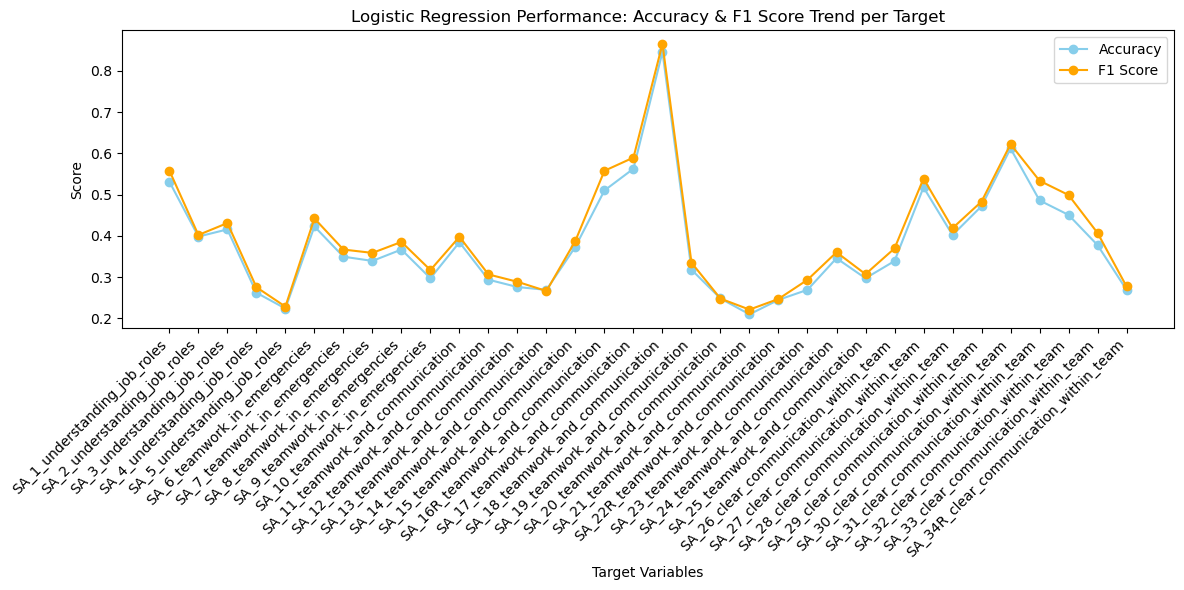

                                    Target  Accuracy  F1 Score
0             SA_1_understanding_job_roles  0.531458  0.558303
1             SA_2_understanding_job_roles  0.398367  0.402209
2             SA_3_understanding_job_roles  0.415729  0.431105
3             SA_4_understanding_job_roles  0.262250  0.275649
4             SA_5_understanding_job_roles  0.223956  0.228543
5             SA_6_teamwork_in_emergencies  0.422868  0.442308
6             SA_7_teamwork_in_emergencies  0.349607  0.366903
7             SA_8_teamwork_in_emergencies  0.339322  0.358765
8             SA_9_teamwork_in_emergencies  0.366909  0.385379
9            SA_10_teamwork_in_emergencies  0.297338  0.317234
10        SA_11_teamwork_and_communication  0.384574  0.397859
11        SA_12_teamwork_and_communication  0.293829  0.306609
12        SA_13_teamwork_and_communication  0.276044  0.288735
13        SA_14_teamwork_and_communication  0.269208  0.266343
14        SA_15_teamwork_and_communication  0.373987  0

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score, accuracy_score

# -------------------------------
# Data Loading and Preparation
# -------------------------------
file_path = r'C:\Users\Χρήστος\Desktop\Aviation_Project\Preprocessed_file.csv'
data = pd.read_csv(file_path, encoding='latin1')

# Define target columns
target_columns = [
    "SA_1_understanding_job_roles", "SA_2_understanding_job_roles", "SA_3_understanding_job_roles", 
    "SA_4_understanding_job_roles", "SA_5_understanding_job_roles", "SA_6_teamwork_in_emergencies", 
    "SA_7_teamwork_in_emergencies", "SA_8_teamwork_in_emergencies", "SA_9_teamwork_in_emergencies", 
    "SA_10_teamwork_in_emergencies", "SA_11_teamwork_and_communication", "SA_12_teamwork_and_communication", 
    "SA_13_teamwork_and_communication", "SA_14_teamwork_and_communication", "SA_15_teamwork_and_communication", 
    "SA_16R_teamwork_and_communication", "SA_17_teamwork_and_communication", "SA_18_teamwork_and_communication", 
    "SA_19_teamwork_and_communication", "SA_20_teamwork_and_communication", "SA_21_teamwork_and_communication", 
    "SA_22R_teamwork_and_communication", "SA_23_teamwork_and_communication", "SA_24_teamwork_and_communication", 
    "SA_25_teamwork_and_communication", "SA_26_clear_communication_within_team", "SA_27_clear_communication_within_team", 
    "SA_28_clear_communication_within_team", "SA_29_clear_communication_within_team", "SA_30_clear_communication_within_team", 
    "SA_31_clear_communication_within_team", "SA_32_clear_communication_within_team", "SA_33_clear_communication_within_team", 
    "SA_34R_clear_communication_within_team"
]

# Separate input features and targets
input_features = data.drop(columns=target_columns)
targets = data[target_columns]

# Scale the input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(input_features)

# ---------------------------------------------------------
# Model Training & Evaluation per Target
# ---------------------------------------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = []

for target in target_columns:
    fold_f1_scores = []
    fold_accuracy_scores = []
    
    for train_index, test_index in kf.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = targets.iloc[train_index][target], targets.iloc[test_index][target]
        
        # Logistic Regression model
        lr_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
        lr_model.fit(X_train, y_train)
        y_pred = lr_model.predict(X_test)
        
        fold_f1_scores.append(f1_score(y_test, y_pred, average='weighted', zero_division=0))
        fold_accuracy_scores.append(accuracy_score(y_test, y_pred))
    
    # Store average results for this target
    results.append({
        "Target": target,
        "Accuracy": np.mean(fold_accuracy_scores),
        "F1 Score": np.mean(fold_f1_scores)
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# ---------------------------------------------------------
# Line plot for Accuracy and F1 Score per Target
# ---------------------------------------------------------
plt.figure(figsize=(12, 6))
plt.plot(results_df['Target'], results_df['Accuracy'], marker='o', label='Accuracy', color='skyblue')
plt.plot(results_df['Target'], results_df['F1 Score'], marker='o', label='F1 Score', color='orange')

plt.xlabel("Target Variables")
plt.ylabel("Score")
plt.title("Logistic Regression Performance: Accuracy & F1 Score Trend per Target")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# Print results table
print(results_df)


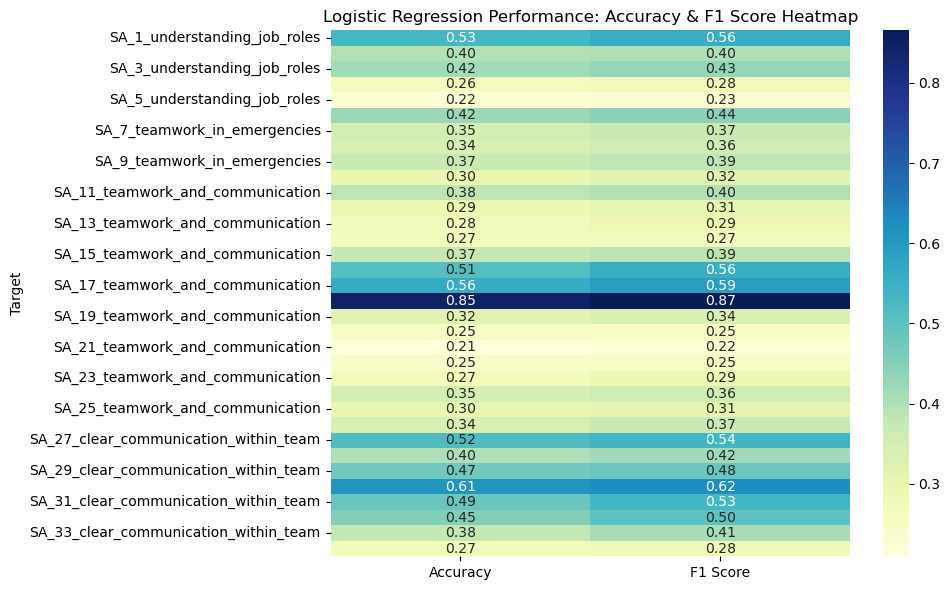

                                    Target  Accuracy  F1 Score
0             SA_1_understanding_job_roles  0.531458  0.558303
1             SA_2_understanding_job_roles  0.398367  0.402209
2             SA_3_understanding_job_roles  0.415729  0.431105
3             SA_4_understanding_job_roles  0.262250  0.275649
4             SA_5_understanding_job_roles  0.223956  0.228543
5             SA_6_teamwork_in_emergencies  0.422868  0.442308
6             SA_7_teamwork_in_emergencies  0.349607  0.366903
7             SA_8_teamwork_in_emergencies  0.339322  0.358765
8             SA_9_teamwork_in_emergencies  0.366909  0.385379
9            SA_10_teamwork_in_emergencies  0.297338  0.317234
10        SA_11_teamwork_and_communication  0.384574  0.397859
11        SA_12_teamwork_and_communication  0.293829  0.306609
12        SA_13_teamwork_and_communication  0.276044  0.288735
13        SA_14_teamwork_and_communication  0.269208  0.266343
14        SA_15_teamwork_and_communication  0.373987  0

In [6]:
# ---------------------------------------------------------
# Heatmap of Accuracy and F1 Score
# ---------------------------------------------------------
import seaborn as sns

score_matrix = results_df.set_index('Target')[['Accuracy', 'F1 Score']]

plt.figure(figsize=(10, 6))
sns.heatmap(score_matrix, annot=True, cmap="YlGnBu", fmt='.2f', cbar=True)

plt.title("Logistic Regression Performance: Accuracy & F1 Score Heatmap")
plt.tight_layout()
plt.show()

# Print results table
print(results_df)